<h1>Hybrid Movie Recommender System for Mobile Devices</h1>

<h2>Module 1: Data Pre-Processing</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import pickle
from matplotlib import pyplot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
#!pip install surprise
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from collections import defaultdict


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
moviesdata= pd.read_csv('movies.csv')
tagsdata= pd.read_csv('tags.csv')
ratingsdata= pd.read_csv('ratings.csv')

In [5]:

ratingsdata=ratingsdata.sample(n=5000000)
moviesdata

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [6]:
moviesdata['genres']=moviesdata['genres'].str.replace('|',' ')

In [7]:
len(moviesdata.movieId.unique())

62423

In [8]:
ratingsdata

,userId,movieId,rating,timestamp
6915171,44875,2174,5.0,1496170918
16907955,109645,4963,3.5,1458433210
11834568,76710,50872,4.5,1198447278
5244129,34070,6333,3.5,1075231184
10025015,65050,1580,1.0,1103100220
...,...,...,...,...
19439995,126191,3972,4.0,1086493421
18609587,120598,1247,4.5,1069812232
10607814,68849,6186,3.5,1111724231
14485017,93805,2959,5.0,1449797822


In [9]:
#The rating data can be shrinked to consider only the users that have rated more than 30 movies.
filtered_ratings=ratingsdata.groupby('userId').filter(lambda x:len(x)>= 30)
#This allows the data to retain most of the movies while reducing the amount of users.
mlr = filtered_ratings.movieId.unique().tolist()
titlesremaining = len(filtered_ratings.movieId.unique())/len(moviesdata.movieId.unique()) * 100


In [10]:
# we take only the unique movie titles that are also present in the new filtered data.
moviesdata=moviesdata[moviesdata.movieId.isin(mlr)]

In [11]:
moviesdata.head(10)
# so now we have the genres without the | seperators

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action Crime Thriller
6,7,Sabrina (1995),Comedy Romance
7,8,Tom and Huck (1995),Adventure Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action Adventure Thriller


In [12]:
Mapit = dict(zip(moviesdata.title.tolist(),moviesdata.movieId.tolist()))
#create a dictionary for movie titles and id for fast lookup

In [13]:
#getting rid of timestamp column as it is not needed
tagsdata.head
tagsdata.drop(['timestamp'],1,inplace=True)
filtered_ratings.drop(['timestamp'],1, inplace=True)

In [14]:
#merging the dataframes to get consolidated dataset
mxmat=pd.merge(moviesdata,tagsdata,on='movieId',how='left')
mxmat.head(10)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,791.0,Owned
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1048.0,imdb top 250
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1361.0,Pixar
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3164.0,Pixar
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3164.0,time travel
5,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3448.0,children
6,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3448.0,comedy
7,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3448.0,funny
8,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3448.0,witty
9,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,4676.0,rated-G


In [15]:
mxmat.fillna("",inplace=True)
mxmat = pd.DataFrame(mxmat.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
finmat = pd.merge(moviesdata, mxmat, on='movieId', how='left')
finmat ['metdat'] = finmat[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)
finmat[['movieId','title','metdat']].head(10)
# combining tags and genres to generte data for content based recommendation later

,movieId,title,metdat
0,1,Toy Story (1995),Owned imdb top 250 Pixar Pixar time travel chi...
1,2,Jumanji (1995),Robin Williams time travel fantasy based on ch...
2,3,Grumpier Old Men (1995),funny best friend duringcreditsstinger fishing...
3,4,Waiting to Exhale (1995),based on novel or book chick flick divorce int...
4,5,Father of the Bride Part II (1995),aging baby confidence contraception daughter g...
5,6,Heat (1995),imdb top 250 great acting realistic action sus...
6,7,Sabrina (1995),remake chauffeur fusion long island millionair...
7,8,Tom and Huck (1995),based on a book Mark Twain Peter Hewitt adapte...
8,9,Sudden Death (1995),explosive hostage terrorist vice president Jea...
9,10,GoldenEye (1995),007 Bond boys with toys gadgets secret service...


In [16]:
print('Percentage of titles remaining in dataset out of original:')
print(titlesremaining)
termfrinvfr=TfidfVectorizer(stop_words='english')
termfrinvfr_matrix=termfrinvfr.fit_transform(finmat['metdat'])
termfrinvfr_df = pd.DataFrame(termfrinvfr_matrix.toarray(), index=finmat.index.tolist())
# using stopwords from sklearn library to generate tf-idf matrix
#print(termfrinvfr_df.shape)

Percentage of titles remaining in dataset out of original:
62.58910978325297


In [17]:
singularVD = TruncatedSVD(n_components=200)
intermatgen = singularVD.fit_transform(termfrinvfr_matrix)
n = 200 
intermatgen_1_df = pd.DataFrame(intermatgen[:,0:n], index=finmat.title.tolist())
intermatgen.shape

(39070, 200)

In [18]:
filtered_ratings.head(10)

,userId,movieId,rating
6915171,44875,2174,5.0
11834568,76710,50872,4.5
9037525,58885,7153,5.0
2260856,15059,175303,5.0
21088093,137072,137857,4.0
5926187,38412,3105,5.0
22901564,148789,160080,4.0
17942119,116262,4979,3.5
15389136,99726,551,3.5
17686493,114638,593,4.5


In [19]:
filtered_ratings1 = pd.merge(moviesdata[['movieId']], filtered_ratings, on="movieId", how="right")

In [20]:
filtered_ratings1.head(10)
filtered_ratings2=pd.pivot(filtered_ratings1,index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [21]:
filtered_ratings2.head(10)

userId,2,3,4,9,12,13,18,19,23,31,...,162515,162516,162519,162521,162524,162529,162532,162533,162534,162541
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.5,2.0,0.0,4.5,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,...,0.0,2.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h1>Module 2: Hybrid Recommendations</h1>

In [22]:
len(filtered_ratings.movieId.unique())

39070

In [23]:
singularVD = TruncatedSVD(n_components=200)
intermatgensec = singularVD.fit_transform(filtered_ratings2)
intermatgensecdata = pd.DataFrame(intermatgensec, index=finmat.title.tolist())

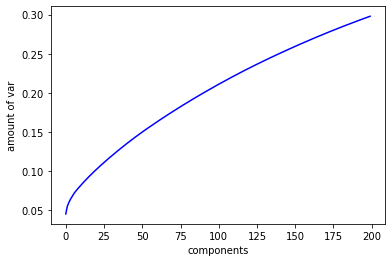

In [24]:
explotter = singularVD.explained_variance_ratio_.cumsum()
plt.plot(explotter,'-', ms = 16, color='blue')
plt.xlabel('components', fontsize= 10)
plt.ylabel('amount of var', fontsize=10)        
plt.show()

In [25]:
simmovie_1= np.array(intermatgen_1_df.loc['Toy Story (1995)']).reshape(1, -1)
simmovie_2 = np.array(intermatgensecdata.loc['Toy Story (1995)']).reshape(1, -1)
conscore = cosine_similarity(intermatgen_1_df, simmovie_1).reshape(-1)
collabscore = cosine_similarity(intermatgensecdata, simmovie_2).reshape(-1)
hybridsim = ((conscore + collabscore)/2.0)
simdic = {'content': conscore , 'collaborative': collabscore, 'hybrid': hybridsim} 
simdf = pd.DataFrame(simdic, index = intermatgen_1_df.index )
simdf.sort_values('content', ascending=False, inplace=True)
#simdf[1:].head(10)

In [26]:
simdf[0:].content.head(10)

Toy Story (1995)         1.000000
Toy Story 2 (1999)       0.931668
Bug's Life, A (1998)     0.894620
Monsters, Inc. (2001)    0.886384
Ratatouille (2007)       0.833410
Finding Nemo (2003)      0.805085
Finding Dory (2016)      0.768618
Ice Age (2002)           0.745094
Big Hero 6 (2014)        0.735973
Toy Story 3 (2010)       0.732900
Name: content, dtype: float64

In [27]:
simdf[0:].collaborative.head(10)

Toy Story (1995)         1.000000
Toy Story 2 (1999)       0.143483
Bug's Life, A (1998)     0.162121
Monsters, Inc. (2001)    0.131443
Ratatouille (2007)       0.166524
Finding Nemo (2003)      0.134792
Finding Dory (2016)      0.185164
Ice Age (2002)           0.152623
Big Hero 6 (2014)        0.198170
Toy Story 3 (2010)       0.247419
Name: collaborative, dtype: float64

In [28]:
simdf[0:].hybrid.head(10)

Toy Story (1995)         1.000000
Toy Story 2 (1999)       0.537576
Bug's Life, A (1998)     0.528371
Monsters, Inc. (2001)    0.508914
Ratatouille (2007)       0.499967
Finding Nemo (2003)      0.469938
Finding Dory (2016)      0.476891
Ice Age (2002)           0.448858
Big Hero 6 (2014)        0.467072
Toy Story 3 (2010)       0.490159
Name: hybrid, dtype: float64

<h1>Final Module:</h1>

In [29]:
def showprecrec(predrat, k=10, threshold=3.5):
    uet = defaultdict(list)
    for uid, _, true_r, est, _ in predrat:
        uet[uid].append((est, true_r))
    precc = dict()
    recc = dict()
    for uid, urats in uet.items():
        urats.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in urats)
        n_rec_k = sum((est >= threshold) for (est, _) in urats[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in urats[:k])
        precc[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recc[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precc, recc

In [30]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(filtered_ratings[['userId','movieId','rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD()
algo.fit(trainset)
predrat = algo.test(testset)
print(accuracy.rmse(predrat, verbose=True)) # rmse 
# can calculate better accuracy[precsion and recall bhi calculate] by using K fold shaayd but then hit ratio 83 tha  idk :(((
# time will inccrrease to about 10 min but :)v
#kf = KFold(n_splits=5)
'''for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predrat = algo.test(testset)
    precc, recc = showprecrec(predrat, k=5, threshold=4)
    print('precision and recall at k')
    print(sum(prec for prec in precc.values()) / len(precc))
    print(sum(rec for rec in recc.values()) / len(recc))
    print(accuracy.rmse(predrat, verbose=True))'''
    

RMSE: 0.8497
0.8496769363362212


"for trainset, testset in kf.split(data):\n    algo.fit(trainset)\n    predrat = algo.test(testset)\n    precc, recc = showprecrec(predrat, k=5, threshold=4)\n    print('precision and recall at k')\n    print(sum(prec for prec in precc.values()) / len(precc))\n    print(sum(rec for rec in recc.values()) / len(recc))\n    print(accuracy.rmse(predrat, verbose=True))"

In [48]:
def recommovie(ui):
    if ui in filtered_ratings.userId.unique():
        listforuser = filtered_ratings[filtered_ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapit.items() if not v in listforuser}        
        predlus = []
        for i, j in d.items():     
            predic = algo.predict(ui, j)
            predlus.append((i, predic[3])) 
        predf = pd.DataFrame(predlus, columns = ['movies', 'ratings'])
        predf.sort_values('ratings', ascending=False, inplace=True)  
        predf.set_index('movies', inplace=True) 
        return predf.head(10)        
    else:
        print("Does not exist")
        return None

In [55]:
recommovie(33316)

,ratings
movies,
Casablanca (1942),4.897250
"Shawshank Redemption, The (1994)",4.888814
"Exterminating Angel, The (Ángel exterminador, El) (1962)",4.863794
Band of Brothers (2001),4.863073
Life (2009),4.847143
Planet Earth (2006),4.837872
Werckmeister Harmonies (Werckmeister harmóniák) (2000),4.837095
The Jinx: The Life and Deaths of Robert Durst (2015),4.826908
"Jetée, La (1962)",4.816185


In [37]:
uusers = filtered_ratings.userId.unique()

In [38]:
uusers

array([ 44875,  76710,  58885, ...,  80488, 132702,  33316])

In [39]:
uusers = uusers[0:50]

In [40]:
uusers
listofusers = uusers.tolist()

In [44]:
from tkinter import *
from tkinter.ttk import Combobox
class mywin:
    def __init__(self, win):
        self.lb1 = Label(win, text='Select the user to recommend for: ')
        #self.lb2 = Label(win, text='RECOMMENDER SYSTEM DEMO')
        data=listofusers
        self.cb=Combobox(window, values=data)
        self.lb=Listbox(window, height=10,width = 70, selectmode='multiple')
        self.cb.place(x=5, y=100)
        self.btn1 = Button(win, text='Add')
        self.b1=Button(win, text='Recommend', command=self.recom)
        self.lb1.place(x=0, y=50)
        #self.lb2.place(x=0,y=10)
        self.b1.place(x=200, y=95)
        self.lb.place(x=300, y=95)
        self.T = Text(win, height=1, width=30,font='Helvetica 12 bold')
        self.T.pack()
        self.T.insert(END, "HYBRID RECOMMENDER SYSTEM")
    def recom(self):
        self.lb.delete(0,END)
        uid = self.cb.get()
        uid = int(uid)
        #print(type(uid))
        op = recommovie(uid)
        finalmovies = op.index.tolist()
        for n in finalmovies:
            self.lb.insert(END,n)
        #print(finalmovies)
        
window=Tk()
mywin=mywin(window)
window.title('Hybrid Recommender System')
window.geometry("800x400+10+10")
window['background']='#003366'
window.mainloop()

In [37]:
listofusers

[39967,
 100358,
 103244,
 15612,
 21185,
 33985,
 120890,
 33349,
 13296,
 26888,
 38552,
 106097,
 64430,
 63247,
 3236,
 124181,
 14856,
 102587,
 41859,
 8805,
 16452,
 56394,
 128854,
 108097,
 120105,
 93808,
 94612,
 104129,
 26926,
 92302,
 554,
 6966,
 62632,
 46470,
 9784,
 66562,
 55261,
 31715,
 42077,
 35109,
 71992,
 85034,
 134627,
 84700,
 25477,
 78781,
 112269,
 119517,
 108123,
 100778]

In [45]:
pickle.dump(algo, open("hybrid.model", 'wb'))

In [50]:
algo2 = pickle.load(open("hybrid.model", 'rb'))

In [51]:
def recommovie2(ui):
    if ui in filtered_ratings.userId.unique():
        listforuser = filtered_ratings[filtered_ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapit.items() if not v in listforuser}        
        predlus = []
        for i, j in d.items():     
            predic = algo2.predict(ui, j)
            predlus.append((i, predic[3])) 
        predf = pd.DataFrame(predlus, columns = ['movies', 'ratings'])
        predf.sort_values('ratings', ascending=False, inplace=True)  
        predf.set_index('movies', inplace=True) 
        return predf.head(10)        
    else:
        print("Does not exist")
        return None

In [53]:
recommovie2(137072)

,ratings
movies,
Planet Earth II (2016),4.450877
Fear and Loathing in Las Vegas (1998),4.330316
Come and See (Idi i smotri) (1985),4.315427
"Dark Knight, The (2008)",4.308501
Life (2009),4.308150
Planet Earth (2006),4.279360
"Royal Tenenbaums, The (2001)",4.259543
Wallace & Gromit: The Best of Aardman Animation (1996),4.255437
42 Up (1998),4.218750


In [56]:
df = recommovie2(137072)

In [73]:
df['ratings'].index

Index(['Planet Earth II (2016)', 'Fear and Loathing in Las Vegas (1998)',
       'Come and See (Idi i smotri) (1985)', 'Dark Knight, The (2008)',
       'Life (2009)', 'Planet Earth (2006)', 'Royal Tenenbaums, The (2001)',
       'Wallace & Gromit: The Best of Aardman Animation (1996)',
       '42 Up (1998)', 'In the Mood For Love (Fa yeung nin wa) (2000)'],
      dtype='object', name='movies')

In [69]:
type(df['ratings'])

pandas.core.series.Series